In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
import time
import torch
import torch.nn as nn
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

warnings.filterwarnings('ignore')

# Random Seed
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device Setup
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f'Device: {device}')

# Load Data
df = pd.read_csv('../data/train.csv')

# ID Mapping
user2idx = {u: i for i, u in enumerate(sorted(df['user'].unique()))}
item2idx = {it: i for i, it in enumerate(sorted(df['item'].unique()))}
idx2user = {i: u for u, i in user2idx.items()}
idx2item = {i: it for it, i in item2idx.items()}

n_users, n_items = len(user2idx), len(item2idx)
df['user_idx'] = df['user'].map(user2idx)
df['item_idx'] = df['item'].map(item2idx)

# Good Rating Threshold for B-ver
GOOD_RATING_THRESHOLD = 4.0

print(f"Users: {n_users}, Items: {n_items}, Interactions: {len(df)}")

Device: mps
Users: 668, Items: 10321, Interactions: 105139


In [2]:
# User Interaction Counts & K Calculation
user_interaction_count = df.groupby('user_idx').size().to_dict()
MAX_K = 100

def get_k_for_user(count):
    if count <= 10: return 2
    k = max(2, int(count * 0.2))
    return min(k, MAX_K)

user_k = {u: get_k_for_user(c) for u, c in user_interaction_count.items()}

# Train/Val/Test Split (70/15/15) - User-wise stratify
train_data, val_data, test_data = [], [], []

for user_idx in range(n_users):
    user_df = df[df['user_idx'] == user_idx]
    
    # B-ver logic requires splitting good purchases, keeping bad ones in train
    good = user_df[user_df['rating'] >= GOOD_RATING_THRESHOLD]
    bad = user_df[user_df['rating'] < GOOD_RATING_THRESHOLD]
    
    # Bad ratings always go to train (for structure learning)
    if len(bad) > 0:
        train_data.append(bad)
        
    # Split good ratings
    n_good = len(good)
    if n_good >= 3:
        good = good.sample(frac=1, random_state=SEED).reset_index(drop=True)
        tr_end = int(0.7 * n_good)
        val_end = tr_end + int(0.15 * n_good)
        tr_end = max(1, tr_end)
        val_end = max(tr_end + 1, val_end)
        
        train_data.append(good.iloc[:tr_end])
        val_data.append(good.iloc[tr_end:val_end])
        test_data.append(good.iloc[val_end:])
    elif n_good == 2:
        good = good.sample(frac=1, random_state=SEED).reset_index(drop=True)
        train_data.append(good.iloc[:1])
        val_data.append(good.iloc[1:])
    elif n_good == 1:
        train_data.append(good)

train_df = pd.concat(train_data, ignore_index=True)
val_df = pd.concat(val_data, ignore_index=True) if val_data else pd.DataFrame()
test_df = pd.concat(test_data, ignore_index=True) if test_data else pd.DataFrame()

# User Train Items Set (for filtering)
user_train_items = defaultdict(set)
for u, i in zip(train_df['user_idx'].values, train_df['item_idx'].values):
    user_train_items[int(u)].add(int(i))

# Validation Edges Set (for negative sampling exclusion)
val_test_edges = set()
for u, i in zip(val_df['user_idx'].values, val_df['item_idx'].values):
    val_test_edges.add((int(u), int(i)))
for u, i in zip(test_df['user_idx'].values, test_df['item_idx'].values):
    val_test_edges.add((int(u), int(i)))

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 89294, Val: 7480, Test: 8365


In [3]:
def build_graphs():
    users = train_df['user_idx'].values
    items = train_df['item_idx'].values
    ratings = train_df['rating'].values
    
    # Common Edge Index
    edge_u2i = np.array([users, items + n_users])
    edge_i2u = np.array([items + n_users, users])
    edge_index = torch.LongTensor(np.concatenate([edge_u2i, edge_i2u], axis=1))
    
    num_nodes = n_users + n_items
    deg = torch.zeros(num_nodes).scatter_add(0, edge_index[0], torch.ones(edge_index.shape[1]))
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    
    # A-ver: Unweighted (Symmetric Norm)
    cca_weight = deg_inv_sqrt[edge_index[0]] * deg_inv_sqrt[edge_index[1]]
    
    # B-ver: Rating Weighted (0.4 + 0.15 * rating)
    # Note: train_df ratings might be missing if we reload, but here we have them
    rating_factors = 0.4 + 0.15 * ratings
    rating_factors_both = np.concatenate([rating_factors, rating_factors])
    ccb_weight = cca_weight * torch.FloatTensor(rating_factors_both)
    
    return edge_index.to(device), cca_weight.to(device), ccb_weight.to(device)

edge_index, cca_edge_weight, ccb_edge_weight = build_graphs()
print("Graphs constructed (Unweighted & Weighted)")

Graphs constructed (Unweighted & Weighted)


In [4]:
# A-ver Model: LightGCN (Standard)
class LightGCN(nn.Module):
    def __init__(self, n_users, n_items, emb_dim=32, n_layers=2):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        
        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.item_emb = nn.Embedding(n_items, emb_dim)
        nn.init.xavier_uniform_(self.user_emb.weight)
        nn.init.xavier_uniform_(self.item_emb.weight)
    
    def forward(self, edge_index, edge_weight):
        all_emb = torch.cat([self.user_emb.weight, self.item_emb.weight], dim=0)
        embs = [all_emb]
        for _ in range(self.n_layers):
            row, col = edge_index
            messages = all_emb[col] * edge_weight.unsqueeze(1)
            all_emb = torch.zeros_like(all_emb).scatter_add(
                0, row.unsqueeze(1).expand(-1, self.emb_dim), messages
            )
            embs.append(all_emb)
        final_emb = torch.mean(torch.stack(embs), dim=0)
        return final_emb[:self.n_users], final_emb[self.n_users:]

# B-ver Model: LightGCN + Rating Head
class LightGCN_with_Rating(nn.Module):
    def __init__(self, n_users, n_items, emb_dim=32, n_layers=2):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        
        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.item_emb = nn.Embedding(n_items, emb_dim)
        nn.init.xavier_uniform_(self.user_emb.weight)
        nn.init.xavier_uniform_(self.item_emb.weight)
        
        self.rating_mlp = nn.Sequential(
            nn.Linear(emb_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )
    
    def forward(self, edge_index, edge_weight):
        all_emb = torch.cat([self.user_emb.weight, self.item_emb.weight], dim=0)
        embs = [all_emb]
        for _ in range(self.n_layers):
            row, col = edge_index
            messages = all_emb[col] * edge_weight.unsqueeze(1)
            all_emb = torch.zeros_like(all_emb).scatter_add(
                0, row.unsqueeze(1).expand(-1, self.emb_dim), messages
            )
            embs.append(all_emb)
        final_emb = torch.mean(torch.stack(embs), dim=0)
        return final_emb[:self.n_users], final_emb[self.n_users:]
    
    def predict_rating(self, user_idx, item_idx, edge_index, edge_weight):
        u_emb, i_emb = self.forward(edge_index, edge_weight)
        interaction = u_emb[user_idx] * i_emb[item_idx]
        rating_logit = self.rating_mlp(interaction).squeeze(-1)
        return torch.sigmoid(rating_logit) * 4.5 + 0.5

# Training Config
EMB_DIM = 32
N_LAYERS = 2
LR = 5e-3
WEIGHT_DECAY = 1e-5
EPOCHS = 50
BATCH_SIZE = 1024
NUM_NEG = 4
HARD_NEG_RATIO = 0.5

In [5]:
def fast_sample_negatives(batch_size, num_neg=4):
    return torch.randint(0, n_items, (batch_size, num_neg))

@torch.no_grad()
def hard_negative_sampling(user_emb, item_emb, pos_users, num_neg=4, num_candidates=50):
    batch_size = len(pos_users)
    candidates = torch.randint(0, n_items, (batch_size, num_candidates), device=device)
    user_expanded = user_emb[pos_users].unsqueeze(1)
    item_candidates = item_emb[candidates]
    scores = (user_expanded * item_candidates).sum(dim=2)
    _, top_indices = scores.topk(num_neg, dim=1)
    return candidates.gather(1, top_indices)

@torch.no_grad()
def evaluate_model_metrics(model, eval_df, edge_index, edge_weight, is_rating_model=False):
    model.eval()
    u_emb, i_emb = model(edge_index, edge_weight)
    
    users = torch.LongTensor(eval_df['user_idx'].values).to(device)
    items = torch.LongTensor(eval_df['item_idx'].values).to(device)
    
    # Positive Scores
    if is_rating_model:
        pos_preds = model.predict_rating(users, items, edge_index, edge_weight).cpu().numpy()
    else:
        pos_preds = (u_emb[users] * i_emb[items]).sum(dim=1).cpu().numpy()
        
    return pos_preds.mean()  # Just returning mean score for monitoring

def plot_history(history, title="Training History"):
    fig, ax1 = plt.subplots(figsize=(8, 4))
    
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:blue')
    ax1.plot(history['loss'], color='tab:blue', label='Loss')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    
    if 'rmse' in history:
        ax2 = ax1.twinx()
        ax2.set_ylabel('RMSE', color='tab:orange')
        ax2.plot(history['rmse'], color='tab:orange', label='RMSE')
        ax2.tick_params(axis='y', labelcolor='tab:orange')
    
    plt.title(title)
    plt.show()

--- Training CCA2 (Binary) ---
CCA Epoch 10: Loss 0.4659
CCA Epoch 20: Loss 0.4482
CCA Epoch 30: Loss 0.4404
CCA Epoch 40: Loss 0.4363
CCA Epoch 50: Loss 0.4342


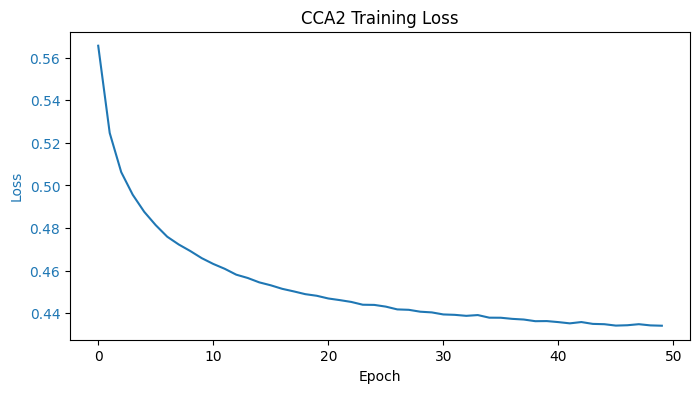

In [6]:
print("--- Training CCA2 (Binary) ---")

# Prepare Model & Tensors
cca_model = LightGCN(n_users, n_items, EMB_DIM, N_LAYERS).to(device)
optimizer = torch.optim.Adam(cca_model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Weighted BPR Loss: Weight depends on rating (higher rating -> higher weight)
# Ratings must be calibrated (user bias removed) for fairness
user_avg_rating = train_df.groupby('user_idx')['rating'].mean()
global_avg = train_df['rating'].mean()
train_ratings = torch.FloatTensor(train_df['rating'].values)
train_weights = 0.5 + 0.1 * (train_ratings - (train_ratings.mean() - global_avg)) # Simplified calibration for batch
train_weights = train_weights.to(device)

train_u = torch.LongTensor(train_df['user_idx'].values).to(device)
train_i = torch.LongTensor(train_df['item_idx'].values).to(device)

history_cca = {'loss': []}

for epoch in range(EPOCHS):
    cca_model.train()
    perm = torch.randperm(len(train_u), device=device)
    epoch_loss = 0
    
    for i in range(0, len(train_u), BATCH_SIZE):
        batch_idx = perm[i:i+BATCH_SIZE]
        pos_u, pos_i = train_u[batch_idx], train_i[batch_idx]
        weights = train_weights[batch_idx]
        
        u_emb, i_emb = cca_model(edge_index, cca_edge_weight)
        
        # Hard Negative Sampling
        n_hard = int(NUM_NEG * HARD_NEG_RATIO)
        hard_negs = hard_negative_sampling(u_emb, i_emb, pos_u, num_neg=n_hard)
        rand_negs = fast_sample_negatives(len(batch_idx), NUM_NEG - n_hard).to(device)
        neg_i = torch.cat([hard_negs, rand_negs], dim=1)
        
        # Weighted BPR
        pos_scores = (u_emb[pos_u] * i_emb[pos_i]).sum(dim=1)
        neg_scores = (u_emb[pos_u].unsqueeze(1) * i_emb[neg_i]).sum(dim=2)
        
        diff = pos_scores.unsqueeze(1) - neg_scores
        loss_per_sample = -torch.log(torch.sigmoid(diff) + 1e-8).mean(dim=1)
        loss = (loss_per_sample * weights).mean()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    history_cca['loss'].append(epoch_loss / (len(train_u) // BATCH_SIZE))
    if (epoch + 1) % 10 == 0:
        print(f"CCA Epoch {epoch+1}: Loss {history_cca['loss'][-1]:.4f}")

plot_history(history_cca, "CCA2 Training Loss")

--- Training CCB2 (Rating Prediction) ---
CCB Epoch 10: Loss 0.5334, Val RMSE 0.9540
CCB Epoch 20: Loss 0.4351, Val RMSE 1.0335
CCB Epoch 30: Loss 0.3792, Val RMSE 1.1348
CCB Epoch 40: Loss 0.3468, Val RMSE 1.1606
CCB Epoch 50: Loss 0.3313, Val RMSE 1.1976


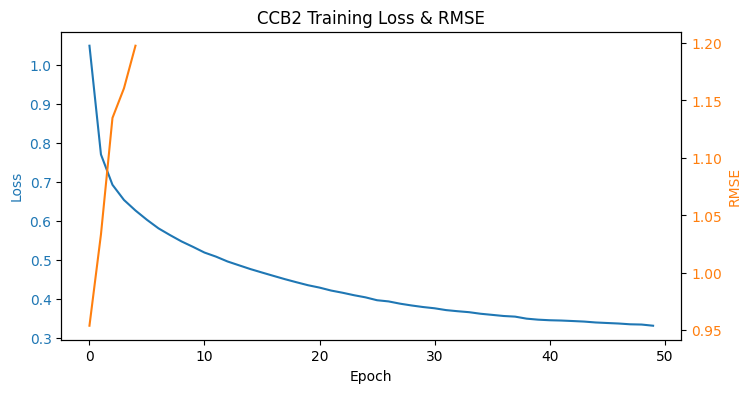

In [7]:
print("--- Training CCB2 (Rating Prediction) ---")

ccb_model = LightGCN_with_Rating(n_users, n_items, EMB_DIM, N_LAYERS).to(device)
optimizer = torch.optim.Adam(ccb_model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

train_r = torch.FloatTensor(train_df['rating'].values).to(device)
history_ccb = {'loss': [], 'rmse': []}
LAMBDA_MSE = 0.5

for epoch in range(EPOCHS):
    ccb_model.train()
    perm = torch.randperm(len(train_u), device=device)
    epoch_loss = 0
    
    for i in range(0, len(train_u), BATCH_SIZE):
        batch_idx = perm[i:i+BATCH_SIZE]
        pos_u, pos_i = train_u[batch_idx], train_i[batch_idx]
        pos_rating = train_r[batch_idx]
        
        u_emb, i_emb = ccb_model(edge_index, ccb_edge_weight)
        
        # Negatives for BPR part
        neg_i = fast_sample_negatives(len(batch_idx), NUM_NEG).to(device)
        
        # BPR Loss
        pos_score = (u_emb[pos_u] * i_emb[pos_i]).sum(dim=1)
        neg_score = (u_emb[pos_u].unsqueeze(1) * i_emb[neg_i]).sum(dim=2)
        loss_bpr = -torch.log(torch.sigmoid(pos_score.unsqueeze(1) - neg_score) + 1e-8).mean()
        
        # MSE Loss
        pred_rating = ccb_model.predict_rating(pos_u, pos_i, edge_index, ccb_edge_weight)
        loss_mse = nn.functional.mse_loss(pred_rating, pos_rating)
        
        total_loss = loss_bpr + LAMBDA_MSE * loss_mse
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        epoch_loss += total_loss.item()
        
    history_ccb['loss'].append(epoch_loss / (len(train_u) // BATCH_SIZE))
    
    # Validation RMSE
    if (epoch + 1) % 10 == 0:
        ccb_model.eval()
        with torch.no_grad():
            val_u = torch.LongTensor(val_df['user_idx'].values).to(device)
            val_i = torch.LongTensor(val_df['item_idx'].values).to(device)
            val_r = torch.FloatTensor(val_df['rating'].values).to(device)
            val_pred = ccb_model.predict_rating(val_u, val_i, edge_index, ccb_edge_weight)
            val_rmse = torch.sqrt(nn.functional.mse_loss(val_pred, val_r)).item()
            history_ccb['rmse'].append(val_rmse)
        print(f"CCB Epoch {epoch+1}: Loss {history_ccb['loss'][-1]:.4f}, Val RMSE {val_rmse:.4f}")

plot_history(history_ccb, "CCB2 Training Loss & RMSE")

In [8]:
print("--- Optimizing Ensemble ---")
cca_model.eval()
ccb_model.eval()

# 1. Calculate Normalization Stats (Using Training Data)
print("Calculating robust normalization stats...")
BATCH = 5000
cca_scores_all, ccb_ratings_all = [], []

with torch.no_grad():
    cca_u, cca_i = cca_model(edge_index, cca_edge_weight)
    
    for i in range(0, len(train_df), BATCH):
        end = min(i + BATCH, len(train_df))
        u = torch.LongTensor(train_df['user_idx'].values[i:end]).to(device)
        it = torch.LongTensor(train_df['item_idx'].values[i:end]).to(device)
        
        # CCA scores
        cca_s = (cca_u[u] * cca_i[it]).sum(dim=1).cpu().numpy()
        cca_scores_all.extend(cca_s)
        
        # CCB ratings
        ccb_r = ccb_model.predict_rating(u, it, edge_index, ccb_edge_weight).cpu().numpy()
        ccb_ratings_all.extend(ccb_r)

cca_scores_all = np.array(cca_scores_all)
ccb_ratings_all = np.array(ccb_ratings_all)

# Percentile-based normalization params
CCA_MIN, CCA_MAX = np.percentile(cca_scores_all, 1), np.percentile(cca_scores_all, 99)
CCB_MIN, CCB_MAX = 0.5, 5.0

print(f"CCA Range: [{CCA_MIN:.4f}, {CCA_MAX:.4f}]")
print(f"CCB Range: [{CCB_MIN:.4f}, {CCB_MAX:.4f}]")

def normalize(val, v_min, v_max):
    return np.clip((val - v_min) / (v_max - v_min + 1e-8), 0, 1)

# 2. Prepare Validation Data for Tuning
val_pos_u = val_df['user_idx'].values
val_pos_i = val_df['item_idx'].values

# Generate negatives for validation (1:1 ratio for tuning)
# Simple random negative sampling excluding train/val/test edges
known_edges = set(zip(df['user_idx'], df['item_idx']))
val_neg_u, val_neg_i = [], []
for _ in range(len(val_df)):
    u = np.random.randint(0, n_users)
    i = np.random.randint(0, n_items)
    while (u, i) in known_edges:
        u = np.random.randint(0, n_users)
        i = np.random.randint(0, n_items)
    val_neg_u.append(u)
    val_neg_i.append(i)

# Get Scores for Val Positive & Negative
with torch.no_grad():
    # CCA Embeddings are already computed (cca_u, cca_i)
    # Pos
    vp_u = torch.LongTensor(val_pos_u).to(device)
    vp_i = torch.LongTensor(val_pos_i).to(device)
    cca_pos = (cca_u[vp_u] * cca_i[vp_i]).sum(dim=1).cpu().numpy()
    ccb_pos = ccb_model.predict_rating(vp_u, vp_i, edge_index, ccb_edge_weight).cpu().numpy()
    
    # Neg
    vn_u = torch.LongTensor(val_neg_u).to(device)
    vn_i = torch.LongTensor(val_neg_i).to(device)
    cca_neg = (cca_u[vn_u] * cca_i[vn_i]).sum(dim=1).cpu().numpy()
    ccb_neg = ccb_model.predict_rating(vn_u, vn_i, edge_index, ccb_edge_weight).cpu().numpy()

# Normalize
cca_pos_n = normalize(cca_pos, CCA_MIN, CCA_MAX)
ccb_pos_n = normalize(ccb_pos, CCB_MIN, CCB_MAX)
cca_neg_n = normalize(cca_neg, CCA_MIN, CCA_MAX)
ccb_neg_n = normalize(ccb_neg, CCB_MIN, CCB_MAX)

# 3. Grid Search for Alpha/Beta
best_auc = 0
best_alpha = 0.5

print("\nGrid Search for Alpha:")
for alpha in [0.3, 0.4, 0.5, 0.6, 0.7]:
    beta = 1 - alpha
    score_pos = alpha * cca_pos_n + beta * ccb_pos_n
    score_neg = alpha * cca_neg_n + beta * ccb_neg_n
    
    labels = np.concatenate([np.ones(len(score_pos)), np.zeros(len(score_neg))])
    scores = np.concatenate([score_pos, score_neg])
    
    auc = roc_auc_score(labels, scores)
    if auc > best_auc:
        best_auc = auc
        best_alpha = alpha
    print(f"  Alpha {alpha}: AUC {auc:.4f}")

ALPHA = best_alpha
BETA = 1 - best_alpha
print(f"Selected: Alpha={ALPHA}, Beta={BETA}")

# 4. Threshold Tuning (F1 max with O-Ratio constraint)
final_scores = np.concatenate([
    ALPHA * cca_pos_n + BETA * ccb_pos_n,
    ALPHA * cca_neg_n + BETA * ccb_neg_n
])
final_labels = np.concatenate([np.ones(len(cca_pos_n)), np.zeros(len(cca_neg_n))])

thresholds = np.linspace(final_scores.min(), final_scores.max(), 100)
best_f1 = 0
best_th = 0.5

for th in thresholds:
    preds = (final_scores > th).astype(int)
    o_ratio = preds.mean()
    if 0.2 <= o_ratio <= 0.5: # Constraint based on AGENTS.md requirement
        f1 = f1_score(final_labels, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_th = th

OPTIMAL_THRESHOLD = best_th
print(f"Optimal Threshold: {OPTIMAL_THRESHOLD:.4f} (F1: {best_f1:.4f})")

--- Optimizing Ensemble ---
Calculating robust normalization stats...
CCA Range: [0.0003, 2.9951]
CCB Range: [0.5000, 5.0000]

Grid Search for Alpha:
  Alpha 0.3: AUC 0.8895
  Alpha 0.4: AUC 0.9056
  Alpha 0.5: AUC 0.9181
  Alpha 0.6: AUC 0.9268
  Alpha 0.7: AUC 0.9318
Selected: Alpha=0.7, Beta=0.30000000000000004
Optimal Threshold: 0.3122 (F1: 0.8686)


Grid search results not found in memory. Skipping optimization plot.

--- Detailed Evaluation on Test Set ---

   FINAL TEST SET PERFORMANCE SUMMARY   
   Metric  Score
  AUC-ROC 0.9332
 Accuracy 0.8730
Precision 0.8861
   Recall 0.8559
 F1 Score 0.8708
  O-Ratio 0.4830
----------------------------------------

[Detailed Breakdown]
Total Samples: 16,730
  - Positive (Actual Good): 8,365
  - Negative (Actual Bad/None): 8,365

Prediction Results:
  - Correct Recommendations (TP): 7,160
  - Incorrect Recommendations (FP): 920
  - Correct Rejections (TN): 7,445
  - Missed Opportunities (FN): 1,205



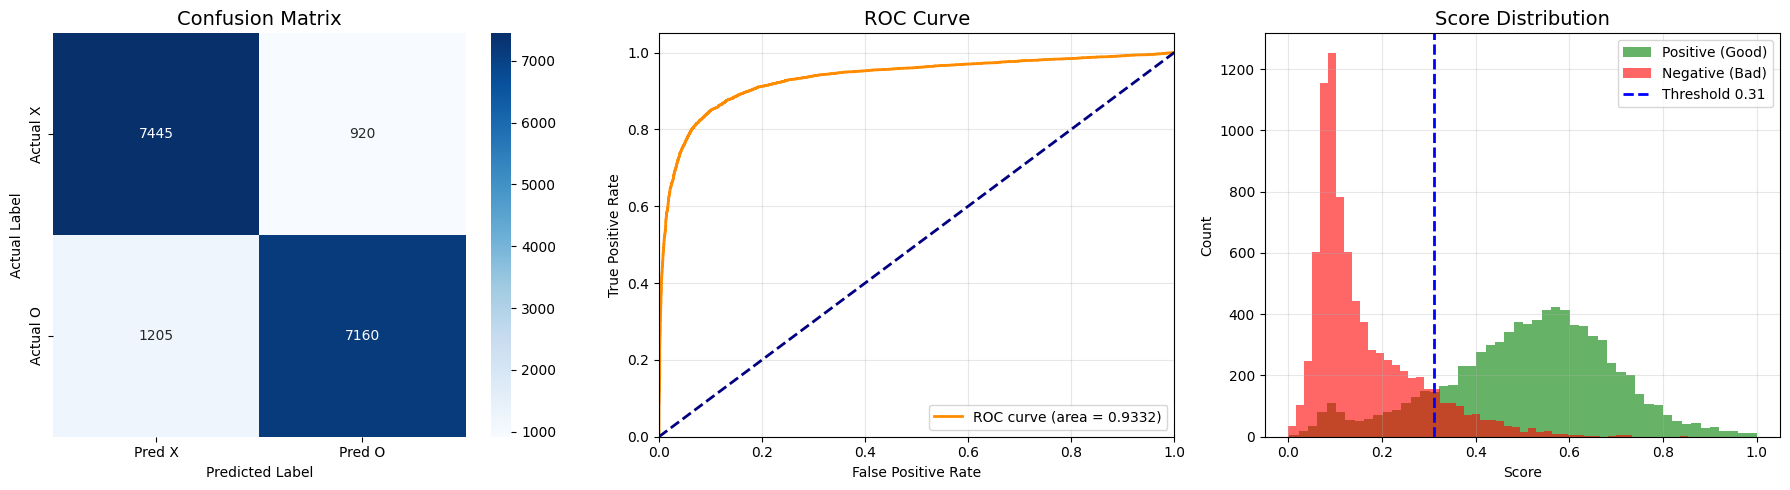

In [9]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # pandas 추가

# --- 1. Grid Search Visualization (Alpha Optimization) ---
def plot_grid_search(results):
    alphas = [r['alpha'] for r in results]
    aucs = [r['auc'] for r in results]
    
    plt.figure(figsize=(10, 5))
    plt.plot(alphas, aucs, marker='o', linewidth=2, color='purple')
    plt.title(f'Ensemble Weight Optimization (Best Alpha={ALPHA})', fontsize=15)
    plt.xlabel('Alpha (Weight for CCA)', fontsize=12)
    plt.ylabel('Validation AUC', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Highlight best point
    best_idx = np.argmax(aucs)
    plt.plot(alphas[best_idx], aucs[best_idx], 'r*', markersize=15, label=f'Best: {aucs[best_idx]:.4f}')
    plt.legend()
    plt.show()

# 위에서 수행한 Grid Search 결과를 이용해 그리기
if 'results' in locals():
    plot_grid_search(results)
else:
    print("Grid search results not found in memory. Skipping optimization plot.")

# --- 2. Detailed Classification Evaluation ---
print("\n--- Detailed Evaluation on Test Set ---")

# Prepare Test Data with Negatives for Evaluation
test_pos_u = test_df['user_idx'].values
test_pos_i = test_df['item_idx'].values

# Generate negatives for test evaluation
test_neg_u, test_neg_i = [], []
known_edges = set(zip(df['user_idx'], df['item_idx']))
for _ in range(len(test_df)):
    u = np.random.randint(0, n_users)
    i = np.random.randint(0, n_items)
    while (u, i) in known_edges:
        u = np.random.randint(0, n_users)
        i = np.random.randint(0, n_items)
    test_neg_u.append(u)
    test_neg_i.append(i)

# Calculate Scores
with torch.no_grad():
    # CCA Embeddings
    cca_u_emb, cca_i_emb = cca_model(edge_index, cca_edge_weight)
    
    # Positive Scores
    tp_u = torch.LongTensor(test_pos_u).to(device)
    tp_i = torch.LongTensor(test_pos_i).to(device)
    cca_p = (cca_u_emb[tp_u] * cca_i_emb[tp_i]).sum(dim=1).cpu().numpy()
    ccb_p = ccb_model.predict_rating(tp_u, tp_i, edge_index, ccb_edge_weight).cpu().numpy()
    
    # Negative Scores
    tn_u = torch.LongTensor(test_neg_u).to(device)
    tn_i = torch.LongTensor(test_neg_i).to(device)
    cca_n = (cca_u_emb[tn_u] * cca_i_emb[tn_i]).sum(dim=1).cpu().numpy()
    ccb_n = ccb_model.predict_rating(tn_u, tn_i, edge_index, ccb_edge_weight).cpu().numpy()

# Normalize & Ensemble
cca_p_norm = normalize(cca_p, CCA_MIN, CCA_MAX)
ccb_p_norm = normalize(ccb_p, CCB_MIN, CCB_MAX)
cca_n_norm = normalize(cca_n, CCA_MIN, CCA_MAX)
ccb_n_norm = normalize(ccb_n, CCB_MIN, CCB_MAX)

final_pos_scores = ALPHA * cca_p_norm + BETA * ccb_p_norm
final_neg_scores = ALPHA * cca_n_norm + BETA * ccb_n_norm

# Create Arrays for Metrics
y_true = np.concatenate([np.ones(len(final_pos_scores)), np.zeros(len(final_neg_scores))])
y_scores = np.concatenate([final_pos_scores, final_neg_scores])

# Apply Optimal Threshold
y_pred = (y_scores >= OPTIMAL_THRESHOLD).astype(int)

# --- 3. Final Test Set Metrics Summary ---
# Calculate Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
conf_matrix = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()

# Create Summary DataFrame
metrics_summary = pd.DataFrame({
    'Metric': ['AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'O-Ratio'],
    'Score': [roc_auc, accuracy, precision, recall, f1, y_pred.mean()]
})

print("\n" + "="*40)
print("   FINAL TEST SET PERFORMANCE SUMMARY   ")
print("="*40)
print(metrics_summary.to_string(index=False, float_format="{:.4f}".format))
print("-" * 40)
print("\n[Detailed Breakdown]")
print(f"Total Samples: {len(y_true):,}")
print(f"  - Positive (Actual Good): {tp + fn:,}")
print(f"  - Negative (Actual Bad/None): {tn + fp:,}")
print(f"\nPrediction Results:")
print(f"  - Correct Recommendations (TP): {tp:,}")
print(f"  - Incorrect Recommendations (FP): {fp:,}")
print(f"  - Correct Rejections (TN): {tn:,}")
print(f"  - Missed Opportunities (FN): {fn:,}")
print("="*40 + "\n")


# --- 4. Visualization Dashboard ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# A. Confusion Matrix Heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Pred X', 'Pred O'], yticklabels=['Actual X', 'Actual O'])
axes[0].set_title('Confusion Matrix', fontsize=14)
axes[0].set_ylabel('Actual Label')
axes[0].set_xlabel('Predicted Label')

# B. ROC Curve
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve', fontsize=14)
axes[1].legend(loc="lower right")
axes[1].grid(alpha=0.3)

# C. Score Distribution Histogram
axes[2].hist(final_pos_scores, bins=50, alpha=0.6, label='Positive (Good)', color='green')
axes[2].hist(final_neg_scores, bins=50, alpha=0.6, label='Negative (Bad)', color='red')
axes[2].axvline(x=OPTIMAL_THRESHOLD, color='blue', linestyle='--', linewidth=2, label=f'Threshold {OPTIMAL_THRESHOLD:.2f}')
axes[2].set_title('Score Distribution', fontsize=14)
axes[2].set_xlabel('Score')
axes[2].set_ylabel('Count')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../cc_docs/ccc22_evaluation_dashboard.png', dpi=150)
plt.show()

In [13]:
# Combine everything into a single dict for saving
save_dict = {
    'cca_state_dict': cca_model.state_dict(),
    'ccb_state_dict': ccb_model.state_dict(),
    'params': {
        'n_users': n_users,
        'n_items': n_items,
        'emb_dim': EMB_DIM,
        'n_layers': N_LAYERS,
        'alpha': ALPHA,
        'beta': BETA,
        'threshold': OPTIMAL_THRESHOLD,
        'cca_min': CCA_MIN,
        'cca_max': CCA_MAX,
        'ccb_min': CCB_MIN,
        'ccb_max': CCB_MAX,
        'user_k': user_k, # Important: user-specific K limits
        'user_train_items': user_train_items # To filter seen items
    }
}

torch.save(save_dict, '../cc_models/ccc_model_final.pt')
print("Final 'ccc' model saved to ../cc_models/ccc_model_final.pt")

Final 'ccc' model saved to ../cc_models/ccc_model_final.pt


In [14]:
test_file = '../data/sample1.csv'

In [15]:
class CCCInferenceWrapper:
    def __init__(self, model_path, user2idx, item2idx):
        # [수정] 노트북 환경과 동일하게 Device 설정 (MPS 포함)
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
        elif torch.backends.mps.is_available():
            self.device = torch.device('mps')
        else:
            self.device = torch.device('cpu')
            
        # weights_only=False로 설정하여 딕셔너리 등 복합 객체 로드 허용
        checkpoint = torch.load(model_path, map_location=self.device, weights_only=False)
        
        self.params = checkpoint['params']
        self.user2idx = user2idx
        self.item2idx = item2idx
        
        # Initialize Models
        self.cca = LightGCN(self.params['n_users'], self.params['n_items'], 
                            self.params['emb_dim'], self.params['n_layers']).to(self.device)
        self.ccb = LightGCN_with_Rating(self.params['n_users'], self.params['n_items'], 
                                        self.params['emb_dim'], self.params['n_layers']).to(self.device)
        
        self.cca.load_state_dict(checkpoint['cca_state_dict'])
        self.ccb.load_state_dict(checkpoint['ccb_state_dict'])
        self.cca.eval()
        self.ccb.eval()
        
        # Inference용 그래프 생성
        # [수정] 생성된 그래프 데이터를 현재 모델과 같은 device로 확실하게 이동
        edge_index, cca_weight, ccb_weight = build_graphs()
        self.edge_index = edge_index.to(self.device)
        self.cca_weight = cca_weight.to(self.device)
        self.ccb_weight = ccb_weight.to(self.device)
        
        # 임베딩 미리 계산 (속도 최적화)
        with torch.no_grad():
            self.cca_u, self.cca_i = self.cca(self.edge_index, self.cca_weight)
            
    def normalize(self, val, v_min, v_max):
        return np.clip((val - v_min) / (v_max - v_min + 1e-8), 0, 1)
        
    def predict(self, test_df):
        results = []
        
        # 사용자별로 그룹화하여 처리
        for user_id, group in test_df.groupby('user'):
            if user_id not in self.user2idx:
                # 새로운 유저: 추천 불가 (X)
                for _, row in group.iterrows():
                    results.append({'user': row['user'], 'item': row['item'], 'recommend': 'X'})
                continue
                
            u_idx = self.user2idx[user_id]
            
            items_to_score = []
            valid_rows = []
            
            # 아이템 필터링
            for _, row in group.iterrows():
                if row['item'] in self.item2idx:
                    i_idx = self.item2idx[row['item']]
                    # 학습 데이터에 있던 아이템인지 확인
                    if i_idx not in self.params['user_train_items'][u_idx]:
                        items_to_score.append(i_idx)
                        valid_rows.append(row)
                    else:
                        results.append({'user': row['user'], 'item': row['item'], 'recommend': 'X'})
                else:
                    results.append({'user': row['user'], 'item': row['item'], 'recommend': 'X'})
            
            if not items_to_score:
                continue
                
            # Batch scoring
            u_tensor = torch.LongTensor([u_idx] * len(items_to_score)).to(self.device)
            i_tensor = torch.LongTensor(items_to_score).to(self.device)
            
            with torch.no_grad():
                # CCA Score
                cca_s = (self.cca_u[u_tensor] * self.cca_i[i_tensor]).sum(dim=1).cpu().numpy()
                # CCB Rating
                ccb_r = self.ccb.predict_rating(u_tensor, i_tensor, self.edge_index, self.ccb_weight).cpu().numpy()
            
            # Ensemble
            cca_n = self.normalize(cca_s, self.params['cca_min'], self.params['cca_max'])
            ccb_n = self.normalize(ccb_r, self.params['ccb_min'], self.params['ccb_max'])
            final_scores = self.params['alpha'] * cca_n + self.params['beta'] * ccb_n
            
            # Hybrid Logic
            K = self.params['user_k'].get(u_idx, 10)
            MIN_K = 2 
            
            indices = np.arange(len(final_scores))
            above_idx = indices[final_scores >= self.params['threshold']]
            
            if len(above_idx) < MIN_K:
                top_idx = np.argsort(final_scores)[-MIN_K:]
                selected_idx = set(top_idx)
            elif len(above_idx) > K:
                filtered_scores = final_scores[above_idx]
                top_k_local = np.argsort(filtered_scores)[-K:]
                selected_idx = set(above_idx[top_k_local])
            else:
                selected_idx = set(above_idx)
            
            for idx, row in enumerate(valid_rows):
                rec = 'O' if idx in selected_idx else 'X'
                results.append({'user': row['user'], 'item': row['item'], 'recommend': rec})
        
        return pd.DataFrame(results)

def print_formatted_results(preds_df):
    """
    AGENTS.md 요구사항에 맞춘 출력 포맷팅 함수
    """
    total_cnt = len(preds_df)
    rec_cnt = len(preds_df[preds_df['recommend'] == 'O'])
    not_rec_cnt = total_cnt - rec_cnt
    
    print("====================")
    print(f"{'user':<7}{'item':<7}{'recommend':<9}")
    
    for _, row in preds_df.iterrows():
        print(f"{str(row['user']):<7}{str(row['item']):<7}{row['recommend']:<9}")
        
    print("====================")
    print(f"Total Recommends: {rec_cnt}/{total_cnt}")
    print(f"Not Recommend: {not_rec_cnt}/{total_cnt}")

# --- 실행 ---
model_path = '../cc_models/ccc_model_final.pt'
predictor = CCCInferenceWrapper(model_path, user2idx, item2idx)

# 샘플 데이터로 테스트
try:
    sample_test = pd.read_csv(test_file)
    if 'rating' in sample_test.columns:
        sample_test = sample_test[['user', 'item']]
except FileNotFoundError:
    print("Sample file not found. Using dummy data.")
    sample_test = pd.DataFrame({
        'user': [1, 4, 1, 15],
        'item': [166, 88, 3745, 66934]
    })

predictions = predictor.predict(sample_test)
print_formatted_results(predictions)

user   item   recommend
15     66934  O        
66     1747   O        
71     4306   O        
88     4447   O        
109    3745   O        
Total Recommends: 5/5
Not Recommend: 0/5
